In [1]:
import pandas as pd
import datetime 
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from matplotlib import style
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import datetime
import quandl
import numpy as np

In [17]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime.now()

In [18]:
df = web.DataReader('RDS-B', 'yahoo', start , end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-13,37.750000,35.959999,37.490002,36.290001,5820100.0,36.290001
2020-04-14,36.570000,35.340000,36.099998,35.959999,5154700.0,35.959999
2020-04-15,33.810001,32.500000,33.810001,33.080002,10788700.0,33.080002
2020-04-16,32.299999,31.330000,32.110001,31.629999,7530200.0,31.629999
2020-04-17,34.480000,32.900002,33.049999,34.430000,5809200.0,34.430000


In [19]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=30).mean()
mavg.tail()

Date
2020-04-13    33.237000
2020-04-14    32.930333
2020-04-15    32.564333
2020-04-16    32.097000
2020-04-17    31.776667
Name: Adj Close, dtype: float64

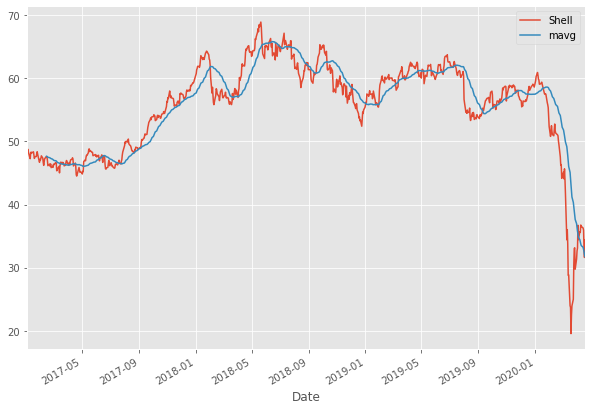

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(10, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='Shell')
mavg.plot(label='mavg')
plt.legend()

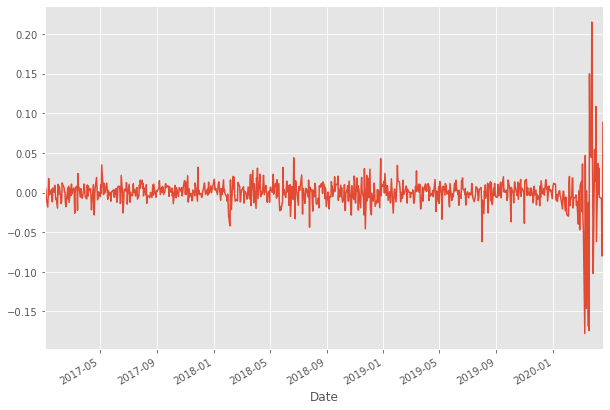

In [21]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [22]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2020-04-13,36.290001,5820100.0,4.932491,-3.200855
2020-04-14,35.959999,5154700.0,3.420466,-0.387810
2020-04-15,33.080002,10788700.0,3.960101,-2.159123
2020-04-16,31.629999,7530200.0,3.066707,-1.494866
2020-04-17,34.430000,5809200.0,4.589015,4.175495


In [23]:
dfreg.corr()

,Adj Close,Volume,HL_PCT,PCT_change
Adj Close,1.000000,-0.583029,-0.504499,0.207587
Volume,-0.583029,1.000000,0.835821,-0.373856
HL_PCT,-0.504499,0.835821,1.000000,-0.386005
PCT_change,0.207587,-0.373856,-0.386005,1.000000


In [24]:
import math
import numpy as np

#Drop missing value
dfreg.fillna(value=-99999, inplace=True)
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2020-04-13,36.290001,5820100.0,4.932491,-3.200855
2020-04-14,35.959999,5154700.0,3.420466,-0.387810
2020-04-15,33.080002,10788700.0,3.960101,-2.159123
2020-04-16,31.629999,7530200.0,3.066707,-1.494866
2020-04-17,34.430000,5809200.0,4.589015,4.175495


In [25]:
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
forecast_out

9

In [26]:
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
X

array([[ 4.82576256e+01,  1.78770000e+06,  1.05441997e+00,
         5.10443748e-02],
       [ 4.85366631e+01,  1.41070000e+06,  6.08726098e-01,
         8.46153950e-02],
       [ 4.87418404e+01,  1.68600000e+06,  7.24028135e-01,
         4.39706269e-01],
       ...,
       [ 3.30800018e+01,  1.07887000e+07,  3.96010067e+00,
        -2.15912308e+00],
       [ 3.16299992e+01,  7.53020000e+06,  3.06670673e+00,
        -1.49486590e+00],
       [ 3.44300003e+01,  5.80920000e+06,  4.58901540e+00,
         4.17549501e+00]])

In [27]:
# Scale the X so that everyone can have the same distribution for linear regression
from sklearn import preprocessing

X = preprocessing.scale(X)
X

array([[-0.95852357, -0.19184102, -0.20842901,  0.14527223],
       [-0.92160385, -0.34537971, -0.51741383,  0.17611681],
       [-0.89445665, -0.23325981, -0.43747874,  0.50236932],
       ...,
       [-2.96668948,  3.47394606,  1.80598331, -1.88539859],
       [-3.15854072,  2.14687494,  1.18662284, -1.27508842],
       [-2.78806989,  1.44597286,  2.24198909,  3.93475955]])

In [28]:
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
X

array([[-0.95852357, -0.19184102, -0.20842901,  0.14527223],
       [-0.92160385, -0.34537971, -0.51741383,  0.17611681],
       [-0.89445665, -0.23325981, -0.43747874,  0.50236932],
       ...,
       [-2.96139743,  4.74485543,  2.70274332, -3.55120396],
       [-2.48507768,  3.14723854,  4.78116611,  1.21267348],
       [-2.78542361,  2.02836099,  3.14571722, -2.99431611]])

In [30]:
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
# y

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [33]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [34]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [36]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confiforest = forest.score(X_test, y_test)

In [37]:
print('Regresion confidence ', confidencereg)
print('poly2 confidence ', confidencepoly2)
print('poly3 confidence ', confidencepoly3)
print('KNN confidence ', confidenceknn)
print('Random Forest confidence ', confiforest)

Regresion confidence  0.8283763168647023
poly2 confidence  0.8493812975628924
poly3 confidence  0.8956993359863045
KNN confidence  0.8563459119573853
Random Forest confidence  0.8781993603506173


In [38]:
# forecast_set = clfreg.predict(X_lately)
forecast_set = forest.predict(X_lately)
dfreg['Forecast'] = np.nan

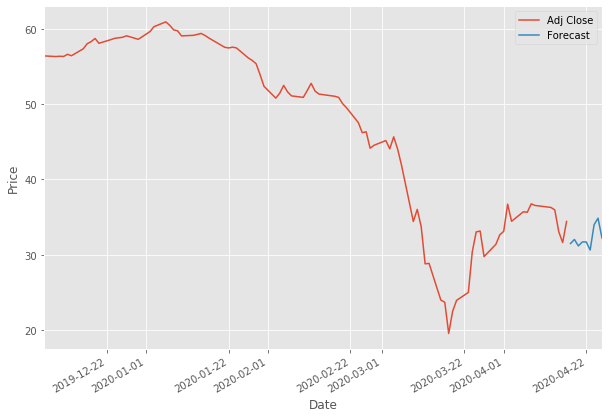

In [39]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(100).plot(gid=1)
dfreg['Forecast'].tail(100).plot(gid=1)
plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [41]:
tail = dfreg.tail(20)
# dfreg.to_csv(x)
tail

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2020-04-02,36.720001,9986500.0,8.251641,1.212796,31.629999,NaN
2020-04-03,34.450001,7239200.0,5.892594,-3.366061,34.430000,NaN
2020-04-06,35.709999,5819400.0,3.696443,2.174530,NaN,NaN
2020-04-07,35.650002,5962000.0,4.628324,-2.328763,NaN,NaN
2020-04-08,36.759998,5817300.0,3.264420,1.715548,NaN,NaN
2020-04-09,36.549999,7095500.0,5.800271,-1.773716,NaN,NaN
2020-04-13,36.290001,5820100.0,4.932491,-3.200855,NaN,NaN
2020-04-14,35.959999,5154700.0,3.420466,-0.387810,NaN,NaN
2020-04-15,33.080002,10788700.0,3.960101,-2.159123,NaN,NaN


In [45]:
dfcomp = web.DataReader(['AC.TO', 'RDS-B', 'BZ=F', 'TOT'],
                        'yahoo', start=start, end=end)['Adj Close']

In [46]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr

Symbols,AC.TO,BZ=F,RDS-B,TOT
Symbols,,,,
AC.TO,1.000000,0.150427,0.461058,0.446827
BZ=F,0.150427,1.000000,0.301269,0.230385
RDS-B,0.461058,0.301269,1.000000,0.819269
TOT,0.446827,0.230385,0.819269,1.000000


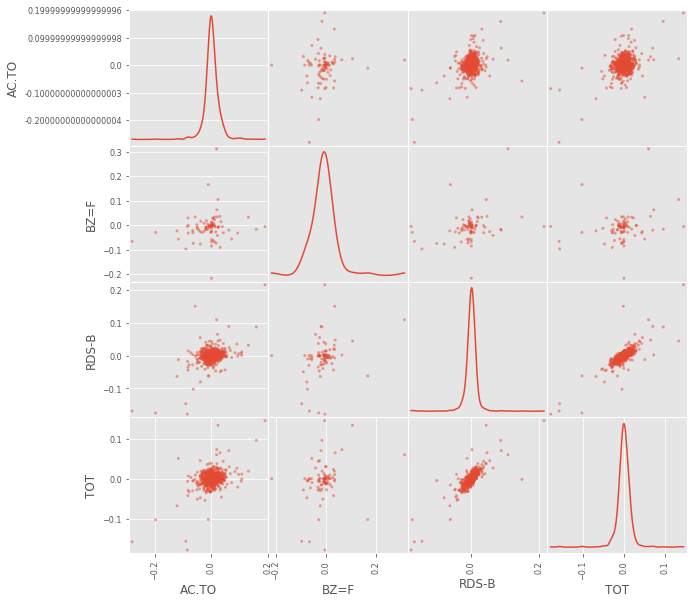

In [47]:
from pandas import plotting
plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));